## Introduction

In this jupyter notebook, we are examining data from DOHMN New York City Restaurant Inspection results.  This data was taken from [here](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59 "Data"), and documented [here](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59/about "Documentation").  Some relevant fields in this dataset include:
   * 'CAMIS', an integer identifier with the restaurant
   * Restaurant name
   * Borough (Manhattan, Bronx, Brooklyn, Queens, or Staten Island)
   * Building number for the street address
   * Street
   * Zipcode
   * Phone number
   * Cuisine Description
   * Inspection date
   * Action resulting from inspection
   * Violation Code
   * Violation Description
   * A "Critical" flag, indicating that violation is among those most likely to contribute to a foodborne illness
   * A numerical score associated with the inspection
   * A letter grade associated with the inspection
   * Date associated with the grade
   * Date associated with the recording by the DOHMN
   * Type of inspection

## Data Cleaning

In the first step of the analysis, we import the data and clean it up so that it is consistent with the specifications established.  This entails:
   * Removing duplicate data
   * Seperating out data corresponding to restaurants which have not had inspections
   * Removing data where the score and grades are inconsistent
   * Removing various punctuation from string fields, to allow for cleaner data output
   * Generating integer data from the date fields, representing the number of days from the earliest recorded event in the given field
   * We do not remove nans at this step, since it is not clear what to replace these values with, and we would like to preserve the maximum amouont of information.  For the all data analysis in this document, we will remove rows containing nans in columns we are concerned with.

In [69]:
# Complete imports relevant for data anlaysis
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


from sklearn import decomposition

# Define file name
file_name = 'DOHMH_New_York_City_Restaurant_Inspection_Results.csv'

# Import file as a pandas data frame
data_frame = pd.read_csv(file_name)

#Set numpy seed
np.random.seed(0)

# Drop duplicated data
duplicated_data_frame = data_frame.drop_duplicates()

# Remove frames with scores < 0
data_frame = data_frame.drop(data_frame[data_frame['SCORE']<0].index)

# Remove frames with scores <- 13 and grades == B or C
data_frame = data_frame.drop(data_frame[(data_frame['SCORE']<=13) & (data_frame['GRADE']=='B')].index)
data_frame = data_frame.drop(data_frame[(data_frame['SCORE']<=13) & (data_frame['GRADE']=='C')].index)

# Remove frames with 13 < scores <- 27 and grades == A or C
data_frame = data_frame.drop(data_frame[(data_frame['SCORE']<=27) & (data_frame['SCORE']>13) & (data_frame['GRADE']=='A')].index)
data_frame = data_frame.drop(data_frame[(data_frame['SCORE']<=27) & (data_frame['SCORE']>13) & (data_frame['GRADE']=='C')].index)

# Remove frames with scores >= 28 and grades == A or B
data_frame = data_frame.drop(data_frame[(data_frame['SCORE']>=28) & (data_frame['GRADE']=='A')].index)
data_frame = data_frame.drop(data_frame[(data_frame['SCORE']>=28) & (data_frame['GRADE']=='B')].index)

#Remove punctuation from string fields
string_fields = ['VIOLATION DESCRIPTION','BORO', 'VIOLATION CODE','STREET', 'ACTION', 'VIOLATION CODE','CUISINE DESCRIPTION','INSPECTION TYPE','GRADE','CRITICAL FLAG']
for field in string_fields:
    idx = data_frame.columns.get_loc(field)
    data_frame.iloc[:,idx] = data_frame.iloc[:,idx].str.replace(r"[\"\',]", '')#str.replace(',', '')


#Seperate uninspected restaurants, defined by inspection_date == '01/01/1900'
uninspected = data_frame[data_frame['INSPECTION DATE'] == '01/01/1900'].drop(columns=['INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'INSPECTION TYPE'])

#Drop uninspected restaurants from main data frame
data_frame = data_frame[data_frame['INSPECTION DATE'] != '01/01/1900']

#Convert inspection and grade dates to integers representing the number of days from the first inspection date recorded
earliest_date = pd.to_datetime(data_frame['INSPECTION DATE']).min()
data_frame['INSPECTION_DAYS_ELAPSED'] = (pd.to_datetime(data_frame['INSPECTION DATE']) - earliest_date).dt.days

earliest_date = pd.to_datetime(data_frame['GRADE DATE']).min()
data_frame['GRADE_DAYS_ELAPSED'] = (pd.to_datetime(data_frame['GRADE DATE']) - earliest_date).dt.days

#Clean up cuisines
data_frame['CUISINE DESCRIPTION'].replace(to_replace='Caf\xc3\x83\xc2\xa9/Coffee/Tea', value='Cafe/Coffee/Tea', inplace = True)

#Clean up violations
data_frame['VIOLATION DESCRIPTION'].replace(to_replace='\xc3\x82\xc2\xba', value=' degrees', inplace = True)
data_frame['VIOLATION DESCRIPTION'].replace(to_replace='\x1a', value='', inplace = True)


## Data Analysis:  Uninspected Restaurants

In the next step of the analysis, we examine some aspects of the data to generate some clean visual statistics.  First, we determine the distribution of uninspected restaurants by borough.  We plot against the borough field because there the limited number of boroughs allow us convey meaning visually.  Afterwards, we plot the inspected restaurants against the borough, to compare.

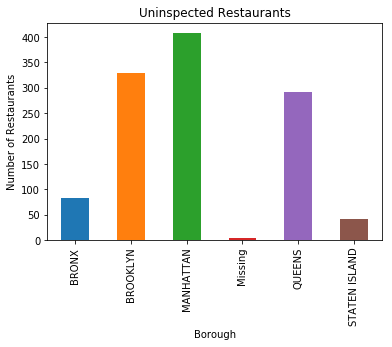

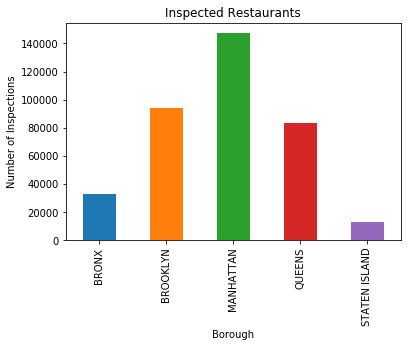

In [29]:
#Create bar graph of number of uninspected restaurants per borough
boro_uninspected_count = uninspected.groupby('BORO').count().iloc[:,0]
uninspected_plot = boro_uninspected_count.plot(kind='bar')
uninspected_plot.set_xlabel('Borough')
uninspected_plot.set_ylabel('Number of Restaurants')
uninspected_plot.set_title('Uninspected Restaurants')
plt.show()

#Create bar graph of number of inspections per borough
boro_count = data_frame.groupby('BORO').count().iloc[:,0]
inspected_plot = boro_count.plot(kind='bar')
inspected_plot.set_xlabel('Borough')
inspected_plot.set_ylabel('Number of Inspections')
inspected_plot.set_title('Inspected Restaurants')
plt.show()

We remark that Brooklyn and Queens appear to be significantly more likely locations for a restaurant to be uninspected.  We note however there are multiple inspections for any given restaurant, which may account for some of the discrepancy between the two distributions.  We investigate the inspection count further in the next section.

## Data Analysis:  Inspection Count

Now, we will consider the extent to which restaurants have had multiple inspections. We create a histogram showing the distribution of restaurants, binning each individual restaurant inside a range of number of inspections.

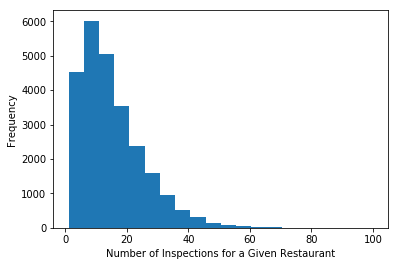

In [24]:
#Plot the distribution of number of inspections for a given restaurant as a histogram
inspection_count_series = data_frame.groupby('CAMIS').count().iloc[:,0] #group by unique restaurant id, CAMIS
inspection_count_plot = inspection_count_series.plot(kind='hist',bins=20)
inspection_count_plot.set_xlabel("Number of Inspections for a Given Restaurant")
plt.show()

There is a peak between 5-10 inspections for a restaurant, with an approximately exponential decrease in frequencies with additional inspections.

Finally, we look at the relationship between the average score of a restaurant and the number of times it has been inspected.

Inspection count/mean score correlation = 
                SCORE          
                 mean     count
SCORE mean   1.000000  0.509264
      count  0.509264  1.000000


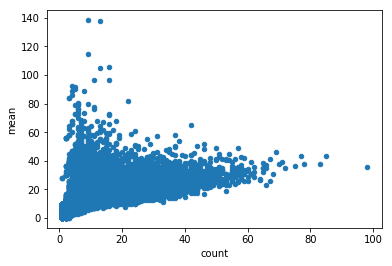

In [25]:
#Remove data for which there is no CAMIS or SCORE information
dropped_nas = data_frame[['CAMIS','SCORE']].dropna(subset=['SCORE'])

#Group by unique restaurant id, CAMIS, and calculate the mean score and a count
inspection_count_score = dropped_nas.groupby(['CAMIS']).agg(['mean', 'count'])

#Visualize the relationship between the mean score and number of inspections associated with a restaurant as a scatterplot.
inspection_count_score['SCORE'].plot.scatter(x='count',y='mean')

#Calculate the correlation
count_score_correlation = inspection_count_score.corr()
print('Inspection count/mean score correlation = ')
print(count_score_correlation)
    

We see that there is a very strong correlation between the mean score and inspection count, shown both by the scatter plot as well as the correlation value of 0.509264.  Because a higher inspection score is associated with more violations, this correlation suggests that a restaurant with more violations is likely to be inspected more frequently.  Additional analysis would be required to verify that the causation runs in the direction proposed.

## Effect of Dataset Fields on Inspection Scores

Now we perform an analysis to determine the correlation between each field and the inspection score.  For categorical variables this requires encoding each field value as a binary indictator, known as "one hot encoding," and a correlation is calculated between each of these binary indicators and the score.

In [84]:
calculate_correlation = True

if calculate_correlation:
    categorical_fields = ['BORO', 'VIOLATION CODE','ZIPCODE','ACTION', 'CUISINE DESCRIPTION','INSPECTION TYPE','GRADE','CRITICAL FLAG', 'VIOLATION DESCRIPTION']#, 'BUILDING']#,'STREET']

    ordinal_fields = ['INSPECTION_DAYS_ELAPSED', 'GRADE_DAYS_ELAPSED']

    for field in categorical_fields:
        #Remove nans
        dropped_nas = data_frame.dropna(subset=['SCORE', field])
        #Categorical variables are converted into dummy binaries (one hot encoding)
        score_frame = pd.get_dummies(dropped_nas[['SCORE', field]],columns=[field])  # , prefix=["code", "desc"])

        #use a minimum of 10 pairs to calculate a correlation
        correlation_table = score_frame.corr(min_periods=10).iloc[1:,:1]
        
        #Define the table as a matrix for numpy operations
        correlations = correlation_table.as_matrix()#np.abs(correlation_table[1:,1])
        
        #Find min and max values in the correlation
        max_index = np.argmax(correlations)
        min_index = np.argmin(correlations)
        print(field+' has maximum correlation with SCORE of '+str(correlations[max_index][0]))
        print(field+' has minimum correlation with SCORE of '+str(correlations[min_index][0]))
        correlation_table.to_csv('SCORE_'+field+'_correlation_table.csv') #Output to file for post-processing

    for field in ordinal_fields:
        # All fields are ordinal, so no binary encoding is necessary.  Still have to remove nans
        dropped_nas = data_frame.dropna(subset=['SCORE', field])
        score_frame = dropped_nas[['SCORE', field]]
        correlation = score_frame.corr().iloc[1:, :1].as_matrix()
        print(field+' has correlation with SCORE of '+str(correlation[0][0]))
        #correlation.to_csv('SCORE_' + field + 'correlation_table.csv') #Output to file for post-processing


BORO has maximum correlation with SCORE of 0.018610211768228975
BORO has minimum correlation with SCORE of -0.017848024763114114
VIOLATION CODE has maximum correlation with SCORE of 0.09790304340399233
VIOLATION CODE has minimum correlation with SCORE of -0.18526514136837857
ZIPCODE has maximum correlation with SCORE of 0.03189261721377589
ZIPCODE has minimum correlation with SCORE of -0.019957815019802295
ACTION has maximum correlation with SCORE of 0.46569276701834716
ACTION has minimum correlation with SCORE of -0.3299556988935808
CUISINE DESCRIPTION has maximum correlation with SCORE of 0.04065480719080502
CUISINE DESCRIPTION has minimum correlation with SCORE of -0.049107355936557295
INSPECTION TYPE has maximum correlation with SCORE of 0.10669285839586282
INSPECTION TYPE has minimum correlation with SCORE of -0.1493505993567664
GRADE has maximum correlation with SCORE of 0.5709882421767248
GRADE has minimum correlation with SCORE of -0.7051418203656221
CRITICAL FLAG has maximum c

We see from the results above that GRADE and ACTION are very strong correlated with SCORE.  At the other end of the spectrum, BORO, ZIPCODE, CUISINE DESCRIPTION, and GRADE_DAYS_ELAPSED have very weak correlations.  The remaining fields tested are intermediate.  We note that the STREET and BUILDING were not tested due to the high dimensionality of these spaces.

## Unsupervised Learning:  Introduction

In the final part of this document, we consider the use of unsupervised learning algorithms to find keywords for the cusine description in the violation description.  We remark that we decided to analyze the cuisine description rather than the zipcode because:
  * The number of cusines is smaller than the number of zipcodes.  Sticking to a lower dimensional allows us decrease the sample complexity and computational complexity of the problem.
  * From the results in the previous section, the cuisine description was somewhat more correlated (positively and negatively) to the score than the zipcode.  Since the score is strongly correlated to the violation description, this suggests we may find more meaningful keywords in the cuisine description space
  * I am not a New York native, and so the zipcodes have little meaning to me, making it more difficult for me to assess the validity of the output.

## Unsupervised Learning:  Feature Transformation

Because both fields to be analyzed are categorical, this introduces some challenges for our analysis.  The typical way categorical data is analyzed using unsupervised learning algorithms is encoding each field as a vector of binary indicators, as we did in the previous section for the correlation calculations.  However, this dramatically increases the dimensionality of our feature space.  

To reduce the complexity of the problem, we first would like to transform our data into a lower dimensional basis. Specifically, we use Principal Component Analysis (PCA) to transform the feature space.  This algorithm computes the covariance matrix associated with the initial feature space.  A new space is constructed out of the eigenvectors of this covariance matrix with the highest eigenvalues.

In the analysis below, we take the set of eigenvectors that are sufficent to explain 95% of the variance as our new feature space.

The data is then projected to our newn feature space.

Original feature space dimension is 179
(68, ' components in PCA explains 95% of the variance')


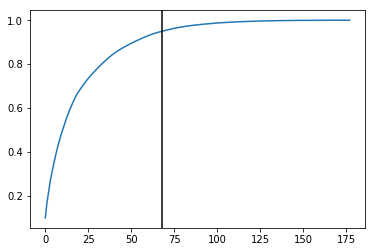

In [47]:
#Feature Transformeration using PCA

other_field = 'CUISINE DESCRIPTION'
#Drop nans
dropped_nas = data_frame.dropna(subset=['VIOLATION DESCRIPTION', other_field])
#Convert categorical data to binary indicators
learning_data = pd.get_dummies(dropped_nas[['VIOLATION DESCRIPTION', other_field]],columns=['VIOLATION DESCRIPTION', other_field])  # , 'ZIPCODE'
learning_data_categorical = dropped_nas[['VIOLATION DESCRIPTION', other_field]]

#Determine dimensionality of the original space
violation_descriptions = dropped_nas['VIOLATION DESCRIPTION'].unique()
violation_descriptions = dropped_nas[other_field].unique()

num_dim1 = np.int(num_violation_descriptions)
num_dim2 = np.int(num_cuisines)
print('Original feature space dimension is '+str(num_dim1+num_dim2))

#Define a header for output
header_array = list(learning_data)

#Get PCA using all data, with num_components=num_features
pca = decomposition.PCA()
pca.fit(learning_data)

#Caclulate normalized eigenvalues, and use cumulative sum to explain percentage variance associated with the first k eigenvectors
pca_cumulative_sum = pca.explained_variance_ratio_.cumsum()

#Truncating the optimal number of components at the marginal eigenvector explaining closest to 95% variance
num_components = (np.abs(pca_cumulative_sum - 0.95)).argmin()
print(num_components, ' components in PCA explains 95% of the variance')
plt.plot(np.arange(pca_cumulative_sum.size), pca_cumulative_sum)
plt.axvline(num_components, color='k', linestyle='solid')
plt.show()

#Use optimal number components calculated for the PCA to fit all data
pca = decomposition.PCA(n_components=num_components)
pca.fit(learning_data)

#Transform the data into the new basis defined by the PCA
pca_transformed_data = pca.transform(learning_data)

#Track the eigenvalues
pca_eigenvalues = pca.explained_variance_

#Track the eigenvectors
pca_eigenvectors = pca.components_

#Save eigenvectors for potential post-processing
np.savetxt('eigenvectors.csv',pca_eigenvectors,delimiter=',',header=str(header_array))



Before we move on, we may extract some meaning from the calculated eigenvectors.  Specifically, if for a given eigenvector, there is a large magnitude component in each of the categorical dimensions, these two key words are correlated. The threshold at which data is output is if the magnitude is larger than 0.1, defined as the pca_truncation_value below.  This may be changed by the user.

In [73]:
#Determine the eigenvectors with the highest values both fields for qualitative intepretation
pca_truncation_value = 0.4

dim1_value = []
dim1_label = []
dim2_value = []
dim2_label = []
i = 0
pca_file = open('best_pca.csv','w')
pca_file.write("PCA eigenvalue, First Label, First Value, Second Label, Second Value\n")
print('Violation, Cuisine')
for k in range(num_components):
    eigenvector_abs = np.abs(pca_eigenvectors[k][:])
    #Maximum components of the eigenvictor in the indices reflecting each of the two fields
    dim1_index = np.argmax(eigenvector_abs[:num_dim1])
    dim2_index = num_dim1+np.argmax(eigenvector_abs[num_dim1:])
    #Output component only if the components are sufficiently high
    if (eigenvector_abs[dim1_index] > pca_truncation_value and eigenvector_abs[dim2_index] > pca_truncation_value):

        dim1_value.append(pca_eigenvectors[k][dim1_index])
        dim1_label.append(header_array[dim1_index])
        dim2_value.append(pca_eigenvectors[k][dim2_index])
        dim2_label.append(header_array[dim2_index])
        
        print(dim1_label[i][22:], dim1_value[i], dim2_label[i][20:], dim2_value[i])
        pca_file.write(','.join([str(pca_eigenvalues[k]), dim1_label[i], str(dim1_value[i]), dim2_label[i], str(dim2_value[i])])+'\n')
        i += 1

pca_file.close()



Violation, Cuisine
('Live roaches present in facilitys food and/or non-food areas.', -0.5255131341387095, 'Pizza/Italian', 0.5177400456054715)
('Food worker does not use proper utensil to eliminate bare hand contact with food that will not receive adequate additional heat treatment.', 0.49291176311898677, 'Seafood', 0.5096237118817477)
('Toilet facility not maintained and provided with toilet paper waste receptacle and self-closing door.', 0.43884718271732065, 'Vietnamese/Cambodian/Malaysia', 0.4920929198403652)


## Unsupervised Learning:  Clustering

Now that we have a new basis, we can cluster our data.  We use k-Means as the first clustering algorithm implemented, although there are other choices available, such as k-Modes and Gaussian Mixture Models.

In the k-Means algorithm, we rely on the new feature space given by the PCA, which is the transformed binary indicator space of our two categorical variables.  This algorithm transforms the domain into k clusters, where every point in a given cluster is closest to the mean of the cluster as defined by an L2 distance metric.  We note that this algorithm is potentially problematic, as the indicator values are binary; values between 0 and 1 have no intuitive meaning.  Gaussian mixture models suffer from the same issue, relying on a potentially erronous distance metric.

The k-Modes algorithm replaces a L2 distance metric with a matching dissimilarity metric, and replaces the means of clusters with modes.  In this way, it can potentially avoid errors associated with k-Means.  k-Modes was  initially implemented using an external library, but the setting a non-random seed would have involved modifying the source of the library.  Therefore, in order to stick with reproducible results, the final algorithm implmented was k-Means.

In order to determine the optimal number of clusters, the dataset is first split into a training and a testing set.  For a given number of clusters, the training set is used to fit the model.  The testing set is used to determine the performance of the clustering model, characterized by an error measure which is defined by the L2 distance between each data point and its associated cluster center.  The number of clusters is progressively increased until the error no longer decreases.

(0, -320948.0655673425)
(1, -287771.84905759257)
(2, -268663.2942314746)
(3, -257898.81092569884)
(4, -243916.36464813648)
(5, -236638.7570412131)
(6, -230200.35363484547)
(7, -217778.61414746838)
(8, -209931.71980130178)
(9, -207197.26703564354)
(10, -198685.27706038006)
(11, -195466.15349193092)
(12, -190311.25978532666)
(13, -183227.3554954295)
(14, -179062.25792272802)
(15, -181165.2966953255)
(16, -176488.68732036717)
(17, -175967.17455014138)
(18, -170962.24086886598)
(19, -168110.9349230533)
(20, -165028.8903239383)
(21, -164660.17100351676)
(22, -160154.30246739954)
(23, -160631.12973562483)
(24, -157092.35417145173)
(25, -153457.10511749415)
(26, -154046.9935401179)
(27, -150891.66714881224)
(28, -150470.17681642197)
(29, -148208.28691120638)
(30, -147200.8578508853)
(31, -143562.79194299056)
(32, -142488.14664570693)
(33, -142162.18390388787)
(34, -140510.07569473205)
(35, -141211.7847202498)
(36, -138254.44607529932)
(37, -137193.46676219668)
(38, -138378.16293366352)
(39, -

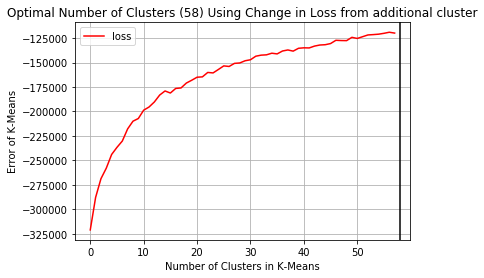

In [80]:
#Flag to use feature space derived from PCA in clustering
use_feature_transformation = True
    

#Split data into a training set and a testing set to avoid over-fitting
if use_feature_transformation:
    learning_train, learning_test = train_test_split(pca_transformed_data, test_size=0.50, random_state=0)
else:
    learning_train, learning_test = train_test_split(learning_data, test_size=0.50, random_state=0)

error = []
num_clusters = 50 #Minimum number of clusters
#Determine inflection point beyond which number of clusters leads to a lower score
for k in range(100):#learning_train.shape[0]):
    #Clustering using K-Means
    kmeans = KMeans(n_clusters=k+1, random_state=0).fit(learning_train)
    error.append(kmeans.score(learning_test))
    print(k, error[k])
    if (k > 50 and error[k] < error[k-1]):
        num_clusters = k+1
        break

print('There should be' + str(num_clusters) + ' clusters')


cluster_plot = plt.plot(np.arange(len(error)), error, c='red', label='error')
plt.axvline(num_clusters, color='k', linestyle='solid')
plt.title('Optimal Number of Clusters')
plt.ylabel('K-Means Error')
plt.xlabel('Number of Clusters in K-Means')
plt.grid()
plt.legend()
plt.show()

Given our optimal cluster size, we cluster all of the available data.  Using our PCA, we transform our clusters back to the original feature space.

With the clusters in the original feature space, we can now find the 'CUISINE DESCRIPTION' key words in the 'VIOLATION DESCRIPTION' space.  We again set a threshold value defined by cluster_truncation_value to limit the output to only cluster that have large components in both the 'CUISINE DESCRIPTION' and 'VIOLATION DESCRIPTION' spaces.  This value has been set conservatively at 0.5, to limit the ouput to a reasonable number for description in this paper.

In [83]:
#If we ran feature transformation, we can cluster in the lower dimensional space
if use_feature_transformation:
    #Fit the data with the specified cluster number
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pca_transformed_data)
    print('Completed kmeans fit')
    #Get cluster centers
    cluster_centers = kmeans.cluster_centers_
    #Transformer the cluster centers into the orignial feature space
    transformed_cluster_centers = pca.inverse_transform(cluster_centers)
    #Save the data for post-processing
    np.savetxt('transformed_kmeans_clusters.csv',transformed_cluster_centers,delimiter=',',header=str(header_array))
else:
    #No nead to transform the clusters to the original feature space
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(learning_data)

    cluster_centers = kmeans.cluster_centers_
    np.savetxt('kmeans_clusters.csv',cluster_centers,delimiter=',',header=str(header_array))

# Determine the clusters with the highest values both fields for qualitative intepretation, this parameter can vary
cluster_truncation_value = 0.95

dim1_value = []
dim1_label = []
dim2_value = []
dim2_label = []
i = 0
cluster_file = open('best_clusters.csv', 'w')
cluster_file.write("Cluster size, First Label, First Value, Second Label, Second Value\n")

print("Violation Label, Cuisine")
for k in range(num_clusters):
    if use_feature_transformation:
        cluster_center = transformed_cluster_centers[k]
    else:
        cluster_center = cluster_centers[k]

    # Maximum components of the cluster centers in the indices reflecting each of the two fields
    dim1_index = np.argmax(cluster_center[:num_dim1])
    dim2_index = num_dim1 + np.argmax(cluster_center[num_dim1:])
    # Output component only if the components are sufficiently high
    if (cluster_center[dim1_index] > cluster_truncation_value and cluster_center[dim2_index] > cluster_truncation_value):
        dim1_value.append(cluster_center[dim1_index])
        dim1_label.append(header_array[dim1_index])
        dim2_value.append(cluster_center[dim2_index])
        dim2_label.append(header_array[dim2_index])

        cluster_file.write(','.join([str(k+1), dim1_label[i], str(dim1_value[i]), dim2_label[i], str(dim2_value[i])])+'\n')
        print(dim1_label[i][22:], dim2_label[i][20:])
        i += 1
    

    
cluster_file.close()

Completed kmeans fit
Violation Label, Cuisine
('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'American')
('Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.', 'American')
('Cold food item held above 41\xc3\x82\xc2\xba F (smoked fish and reduced oxygen packaged foods above 38 \xc3\x82\xc2\xbaF) except during necessary preparation.', 'Chinese')
('Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies little house flies blow flies bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies drain flies and Phorid flies.', 'Pizza')
('Hot food item not held at or above 140\xc3\x

## Unsupervised Learning:  Conclusions

Through our unsupervised learning algorithms, we've generated quite a few violation/cuisine pairs.

Looking at only the more important relationships, the PCA suggests that the following:
  * 'Live roaches present in facilitys food and/or non-food areas.' is negatively correlated with 'Pizza/Italian'
  * 'Food worker does not use proper utensil to eliminate bare hand contact with food that will not receive adequate additional heat treatment.' is correlated with 'Seafood'
  * 'Toilet facility not maintained and provided with toilet paper waste receptacle and self-closing door.' is correlated with 'Vietnamese/Cambodian/Malaysia'
  
The k-Means clustering estimates that the following pairs are positively correlated:

  * ('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'American')
  * ('Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.', 'American')
  * ('Cold food item held above 41 F (smoked fish and reduced oxygen packaged foods above 38 F) except during necessary preparation.', 'Chinese')
  * ('Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies little house flies blow flies bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies drain flies and Phorid flies.', 'Pizza')
  * ('Hot food item not held at or above 140 F.', 'Mexican')
  * ('Food contact surface not properly washed rinsed and sanitized after each use and following any activity when contamination may have occurred.', 'American')
  * ('Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies little house flies blow flies bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies drain flies and Phorid flies.', 'American')
  * ('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'Italian')
  * ('Food not protected from potential source of contamination during storage preparation transportation display or service.', 'Chinese')
  * ('Food contact surface not properly washed rinsed and sanitized after each use and following any activity when contamination may have occurred.', 'Chinese')
  * ('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'Chinese')
  * ('Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly.', 'American')
  * ('Food not protected from potential source of contamination during storage preparation transportation display or service.', 'American')
  * ('Cold food item held above 41 F (smoked fish and reduced oxygen packaged foods above 38 \xc3\x82\xc2\xbaF) except during necessary preparation.', 'American')
  * ('Raw cooked or prepared food is adulterated contaminated cross-contaminated or not discarded in accordance with HACCP plan.', 'American')
  * ('Food not protected from potential source of contamination during storage preparation transportation display or service.', 'Bakery')
  * ('Hot food item not held at or above 140 F.', 'Chinese')
  * ('Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly.', 'Chinese')
  * ('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'Pizza')
  * ('Live roaches present in facilitys food and/or non-food areas.', 'Chinese')
  * ('Hot food item not held at or above 140 F.', 'American')
  * ('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'Spanish')
  * ('Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed raised spaced or movable to allow accessibility for cleaning on all sides above and underneath the unit.', 'Latin (Cuban Dominican Puerto Rican South & Central American)')
  * ('Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.', 'Chinese')
  * ('Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.', 'Bakery')
  * ('Evidence of mice or live mice present in facilitys food and/or non-food areas.', 'Chinese')
  * ('Evidence of mice or live mice present in facilitys food and/or non-food areas.', 'Japanese')

We note that additional relationships could be found by lowering the threshold values.  In addition, only one feature transformation and one clustering algorithm was explored in this paper.  Additional experiments with other algorithms could yield potentially better results.  We note in particular that Multiple Component Analysis (MCA) would be an interesting feature transformation algorithm to explore, and k-Modes would be an interesting clustering algorithm.